## Dimensionality Reduction and Clustering

For this homework we will be using some image data! Specifically, the MNIST data set. You can load this data easily with the following commands:

In [3]:
from sklearn.datasets import fetch_mldata

In [8]:
import tempfile
test_data_home = tempfile.mkdtemp()
mnist = fetch_mldata('MNIST original', data_home=test_data_home)

In [31]:
X = mnist.data / 255.0
y = mnist.target

The MNIST data set is hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

Source: https://www.kaggle.com/c/digit-recognizer/data

For this homework, perform the following with the MNIST data:

1. Use PCA to reduce the dimensionality

    a. How many components did you use? Why?
    
    b. Plot the first two components. Do you notice any trends? What is this plot showing us?
    
    c. Why would you use PCA? What is it doing? And what are the drawbacks?
    
    d. Plot some of the images, then compress them using PCA and plot again. How does it look?
    
2. Use t-SNE to plot the first two components (you should probably random sample around 10000 points):

    a. How does this plot differ from your PCA plot?
    
    b. How robust is it to changes in perplexity?
    
    c. How robust is it to different learning rate and number of iterations?
    
3. Perform k-means clustering:

    a. How did you choose k?
    
    b. How did you evaluate your clustering?
    
    c. Visualize your clusters using t-sne
    
    d. Did you scale your data?
    
    e. How robust is your clustering?
    
4. Perform hierarchical clustering:

    a. Plot your dendrogram
    
    b. How many clusters seem reasonable based off your graph?
    
    c. How does your dendrogram change with different linkage methods?

### Grading

This homework is due **March 22, 2018 by midnight Utah time.** By that time, you need to have committed all your code to your github and submitted a link to your work to the TA. We can see on your Github account when you last committed code. :)

Rubric:

* Code Quality - 10%
* Storytelling - 10%
* PCA - 20%
* T-SNE - 20%
* K-means - 20%
* Hierarchical Clustering - 20%

### METHOD 1: PCA

In [170]:
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Text(0.5,1,'Number Counts')

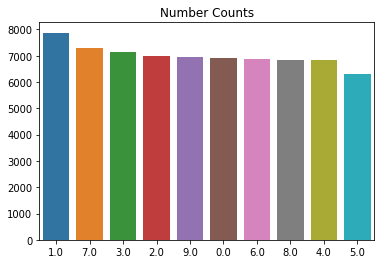

In [196]:
ax = sns.barplot(data=pd.DataFrame(y)[0].value_counts().to_frame().transpose())
ax.set_title('Number Counts')

We see above that our data set is pretty evenly split between the different numbers. Lets try to find the optimal number of components for our model

In [98]:
pca = PCA(n_components=784)
X_pca = pca.fit_transform(X)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)

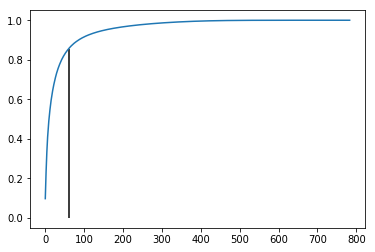

In [201]:
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.vlines(ymin=0,ymax=cum_ratio[60],x=60)

We see that at about 60 features, we really start to decrease in the rate that new features increase explained variance. Also this shows us that we could explain over 85% of the variance using 60 features rather than 784.

In [62]:
print("Variance Explained: {}".format(cum_ratio[60]))

Variance Explained: 0.8556682089437877


The code below is going to give us the number of features at which the rate of variance being explained by adding more features begins to decrease. In other words, this gives us the value that maximizes the second derivative. This could be a good metric to determine the number of features. Although 60 features explain about 85% of our variance, we still have to use 60 features. 6 features explains about 40% of the variance and the rate at which adding more features helps our variance is maximized. 

In [94]:
max1 = 0
val = 1
y1 = 0
for i in range(783):
    j = i + 1
    max2 = cum_ratio[j]-cum_ratio[i]
    y2 = max1-max2
    max1 = max2
    if y2 >= y1:
        val = j
        y1 = y2
        
print("Optimal Number of Features: {}".format(val))
a = "Variance explained with {}".format(val) 
b = " features: {}".format(cum_ratio[val])
print(a + b)

Optimal Number of Features: 6
Variance explained with 6 features: 0.4092689827562226


### Number of Components:
- I'm going to use 64 components
- 64 Is a lot, but it'll explain more than 85% of the variance
- 6 features is just too small
- 64 is square so we can plot easily

In [211]:
pca = PCA(n_components=64)
X_pca = pca.fit_transform(X)

In [232]:
pca = pd.DataFrame(X_pca)
data = pd.concat([pd.DataFrame(y),pca],axis=1)
data.columns = [i for i in range(data.shape[1])]
data.columns = ["c"+str(i) for i in data.columns]

Text(0.5,1,'Scatter Plot of 1st Two Components')

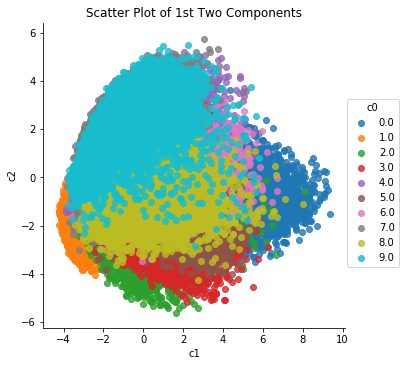

In [235]:
sns.lmplot(x='c1', y='c2', data=data, hue='c0', fit_reg=False)
plt.title('Scatter Plot of 1st Two Components')


We don't see a huge relationship between the first two components. It would be pretty difficult to get any kind of trend from this. We kind of see a weak positive trend. We can see a reasonable grouping between the different numbers, but we wouldn't be able to see any kind of seperation if it weren't for the coloring. 

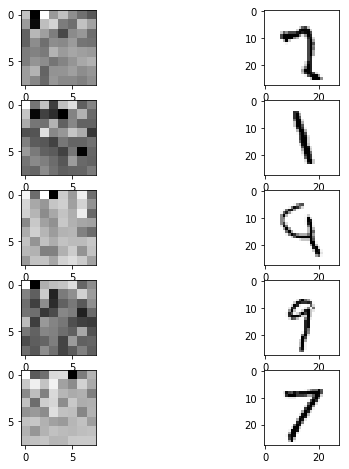

In [203]:
import random
random.seed(47)
ran = random.sample(range(0, 69999), 5)
fig=plt.figure(figsize=(8, 8))
j = 1
for i in ran:
    fig.add_subplot(5, 2, j)
    plt.imshow(X_pca[i].reshape((8,8)), cmap='Greys')
    j = j + 1
    fig.add_subplot(5, 2, j)
    plt.imshow(X[i].reshape((28,28)), cmap='Greys')
    j = j + 1
plt.show()

Above we have 5 random instances of our data. We have the actual image on the left and the PCA compressed image with 64 components (8x8). We have two 9's in this sample, but the PCA images look very different. We also have a 7 that looks kind of like a 2 at the top, but the PCA images are very different. Its difficult to really see a pattern here. 

### Why Use PCA?
Pca is projecting the data onto an axis with the highest variance. In this data, projecting all the data onto one component preserves 17% of the variance found in the original data. PCA creates additional components orthogonally, preserving the 2nd most, 3rd most, etc. possible variance. Thus, if you do PCA with the number of components equal to the original number of features in the data then we have 100% of the variance explained. Thus PCA is a fairly simple way to compress an image using matrix transofmations. The drawback of PCA (as we can see above) is that it can be difficult to interpret the results. The PCA images are super different from regular images. 

### Method 2: t-SNE
Use t-SNE to plot the first two components (you should probably random sample around 10000 points):

    a. How does this plot differ from your PCA plot?
    
    b. How robust is it to changes in perplexity?
    
    c. How robust is it to different learning rate and number of iterations?

Below I am reducing dimensionality to 50 using pca, and then using t-SNE (perplexity: 50, learning rate: 200, iter: 1000)

In [204]:
from sklearn.manifold import TSNE


#first reduce dimensionality before feeding to t-sne
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.065s...
[t-SNE] Computed neighbors for 10000 samples in 30.989s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.923852
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.019737
[t-SNE] Error after 1000 iterations: 1.665118


In [205]:
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = y[rows[:n_select]]

Text(0.5,1,'t-SNE two component scatter plot with number labels')

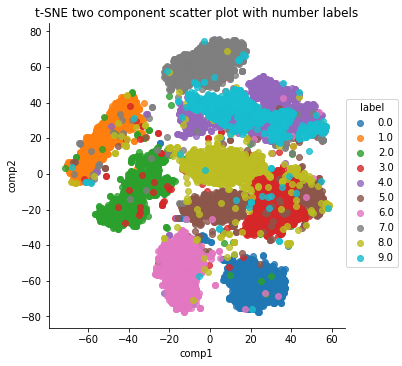

In [210]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
plt.title('t-SNE two component scatter plot with number labels')

Unlike the PCA plot, we see clear seperation between different categories. If only half of the data were labeled, we could fill in the other half without too much difficulty. The categories aren't perfect, but they are pretty good. We see that 9's and 4's overlap alot, 8's, 3's, and 5's are also all pretty close together. 

To test out different learning rates, perplexities, and iterations, i put things into a function, i'll compare the plots of different combinations of hyper parameters. 

In [239]:
def gfun(p,n,l):

    rows = np.arange(70000)
    np.random.shuffle(rows)
    n_select = 10000

    tsne = TSNE(n_components=2, verbose=0, perplexity=p, n_iter=n, learning_rate=l)
    tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])
    df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
    df_tsne['label'] = y[rows[:n_select]]
    ax = sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
    return(ax)


Text(0.5,1,'t-SNE perp=75, iter=1000, l_rate=200')

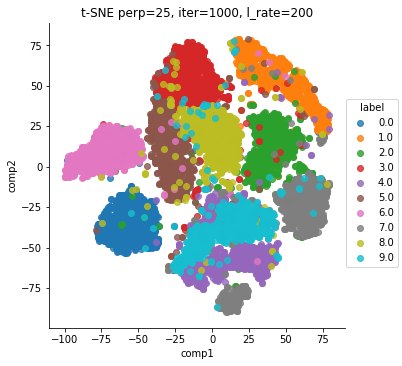

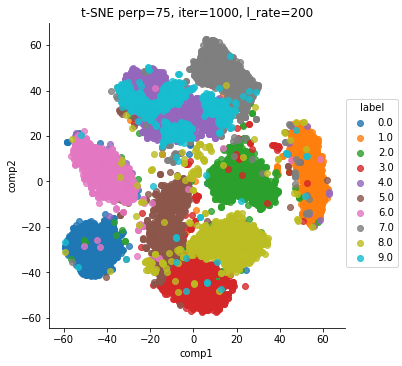

In [247]:
ax = gfun(25,1000,200)
plt.title('t-SNE perp=25, iter=1000, l_rate=200')
ax = gfun(75,1000,200)
plt.title('t-SNE perp=75, iter=1000, l_rate=200')

We see that with varying perplexity (25,50,70) our classification still works pretty well. 

We will now test changing the learning rate and the number of iterations

Text(0.5,1,'t-SNE perp=50, iter=500, l_rate=200')

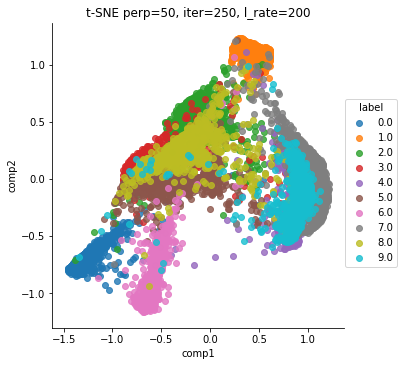

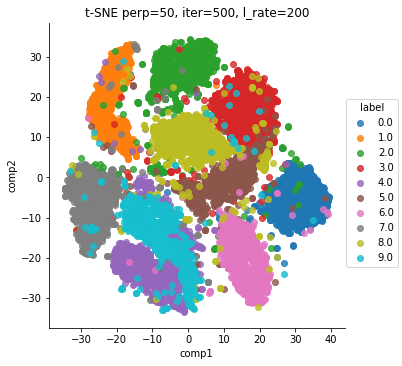

In [248]:
ax = gfun(50,250,200)
plt.title('t-SNE perp=50, iter=250, l_rate=200')
ax = gfun(50,500,200)
plt.title('t-SNE perp=50, iter=500, l_rate=200')

I tried decreasing the number of iterations. I tested 250 and 500. We can see that at lower iterations, things get a little strange and many categories start to merge together. 

Text(0.5,1,'t-SNE perp=50, iter=1000, l_rate=300')

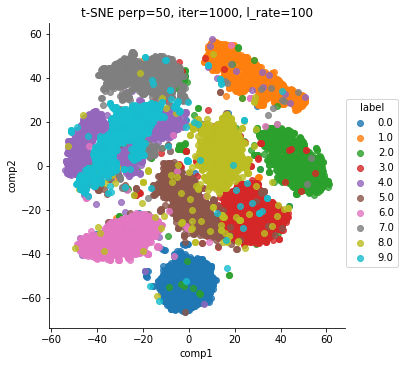

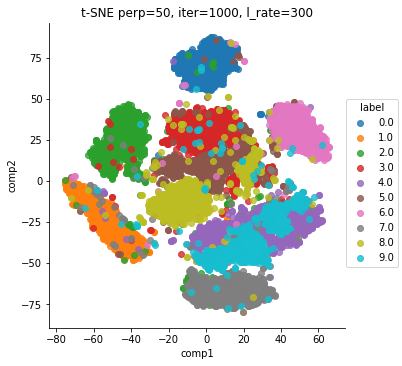

In [246]:
ax = gfun(50,1000,100)
plt.title('t-SNE perp=50, iter=1000, l_rate=100')
ax = gfun(50,1000,300)
plt.title('t-SNE perp=50, iter=1000, l_rate=300')

I also adjusted the learning rate. I tried 100 and 300. Things change quite a bit with the learning rate, but the classification still looks good. 

### t-SNE Results
- t-SNE seems fairly robust to changes in perplexity (within a reasonable range)
- changes in the number of iterations can have a big effect. You need to have enough iterations
- changes in the learning rate don't matter that much as long as they are in a reasonable range. 
- Each of these hyperparameters can effect the time t-sne takes. More iterations can give you better results, but also longer running time. 

Perform k-means clustering:

    a. How did you choose k?
    
    b. How did you evaluate your clustering?
    
    c. Visualize your clusters using t-sne
    
    d. Did you scale your data?
    
    e. How robust is your clustering?
    

K was selected to be 10 because there are 10 numbers. 

I evaluated using Random Index. 

I decided not to scale the data. I didn't scale the data because the distance between the pixel values could be important. 

Because of the computationally intensive nature of kmeans, i am randomly sampling 5000 observations of the data.

In [319]:
from sklearn.cluster import KMeans
from sklearn import metrics
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 5000
x_k= X[rows[:n_select],:]
y_k= y[rows[:n_select]]
kmeans = KMeans(n_clusters=10, n_init=50, n_jobs=-1)
kmeans.fit(x_k)
sk_clusters = kmeans.predict(x_k)
df_k = pd.concat([pd.DataFrame(y_k),pd.DataFrame(sk_clusters)],axis=1)
df_k.columns = ['label','predict']
metrics.adjusted_rand_score(df_k.label, df_k.predict)  

0.36117358684559264

Random index score of .36 seems pretty good. 1 is max, but .36 isn't bad. 

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 2.789s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.167784
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.883072
[t-SNE] Error after 1000 iterations: 1.421025


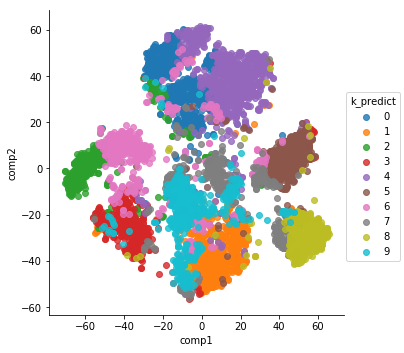

In [321]:
pca = PCA(n_components=50)
X_k1 = pca.fit_transform(x_k)
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_k1)
df_ktsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_ktsne['k_predict'] = sk_clusters
sns.lmplot(x='comp1', y='comp2', data=df_ktsne, hue='k_predict', fit_reg=False)

Our K Means categories seem fairly reasonable when we visualize with t-SNE

Adjusted rand index gives us a score of .66. This is a pretty good score. 1 is the max on this. 

In [322]:
ninit = [10,25,40,60,75,100]
for i in ninit:
    kmeans = KMeans(n_clusters=10, n_init=50, n_jobs=-1)
    kmeans.fit(x_k)
    sk_clusters = kmeans.predict(x_k)
    df_k = pd.concat([pd.DataFrame(y_k),pd.DataFrame(sk_clusters)],axis=1)
    df_k.columns = ['label','predict']
    a = "Adjusted Rand Score with n_init = {}".format(i)
    b = " : {}".format(metrics.adjusted_rand_score(df_k.label, df_k.predict))
    print(a+b)

Adjusted Rand Score with n_init = 10 : 0.35604988632818324
Adjusted Rand Score with n_init = 25 : 0.3558546036804599
Adjusted Rand Score with n_init = 40 : 0.35740975685623544
Adjusted Rand Score with n_init = 60 : 0.35742778835391453
Adjusted Rand Score with n_init = 75 : 0.3612090911646247
Adjusted Rand Score with n_init = 100 : 0.35540122293765325


We can see that changing n_init does not significantly change our results. 

Perform hierarchical clustering:

    a. Plot your dendrogram
    
    b. How many clusters seem reasonable based off your graph?
    
    c. How does your dendrogram change with different linkage methods?

I had to use a subsample of the data to make the dendrogram. I ran into memory errors when i used all of the data. I used the same 5000 random observations that I used for k means

Based on the dendrogram it seems reasonable to have around 8-10 clusters. With more than 10 clusters, clusters combine pretty quickly. 

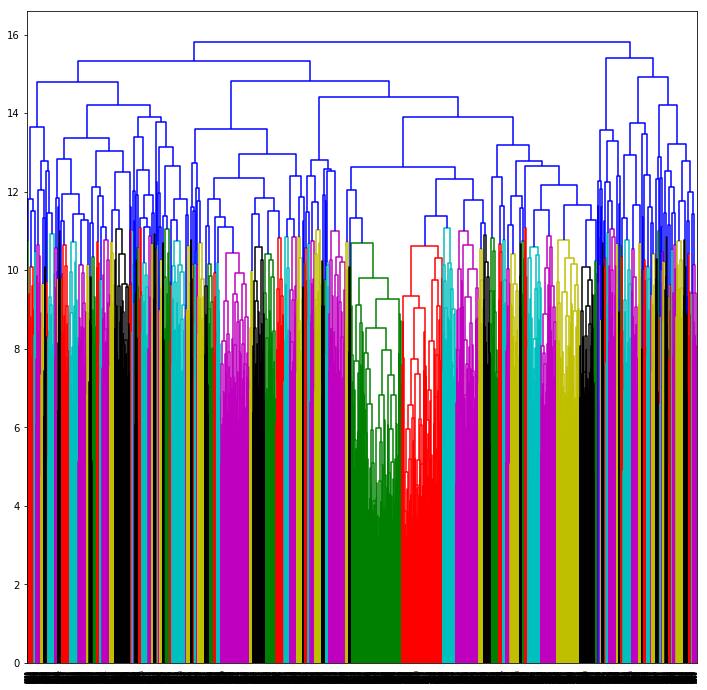

In [324]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(x_k,'complete')
plt.figure(figsize=(12, 12))
_ = dendrogram(Z)

Lets try a few different linkage methods

Ward Method: uses the Ward variance minimization method. 

This method seems excellent. At about 80 we see 10 clear categories that stick around for a while.

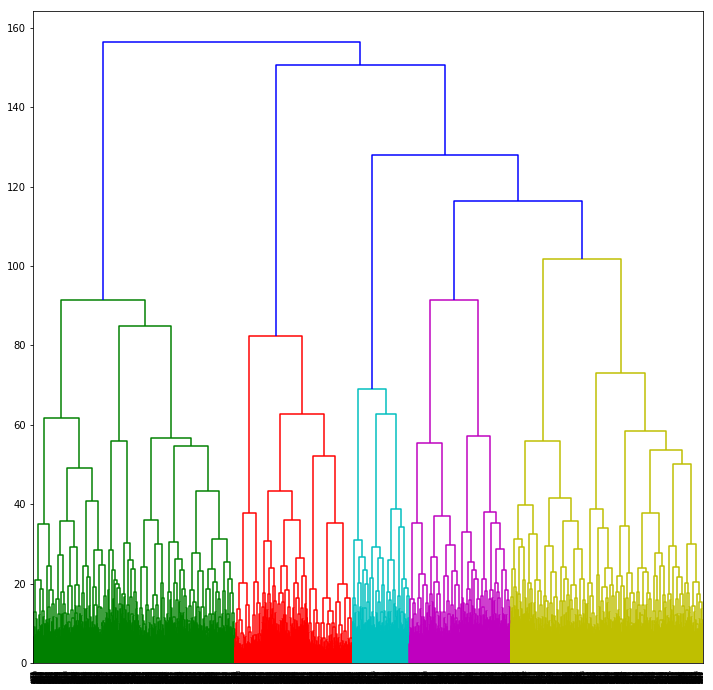

In [325]:
Z = linkage(x_k,'ward')
plt.figure(figsize=(12, 12))
_ = dendrogram(Z)

Weighted Method: Looks awful! We can't really pull any number of classes out of this. Maybe 4 classes. 

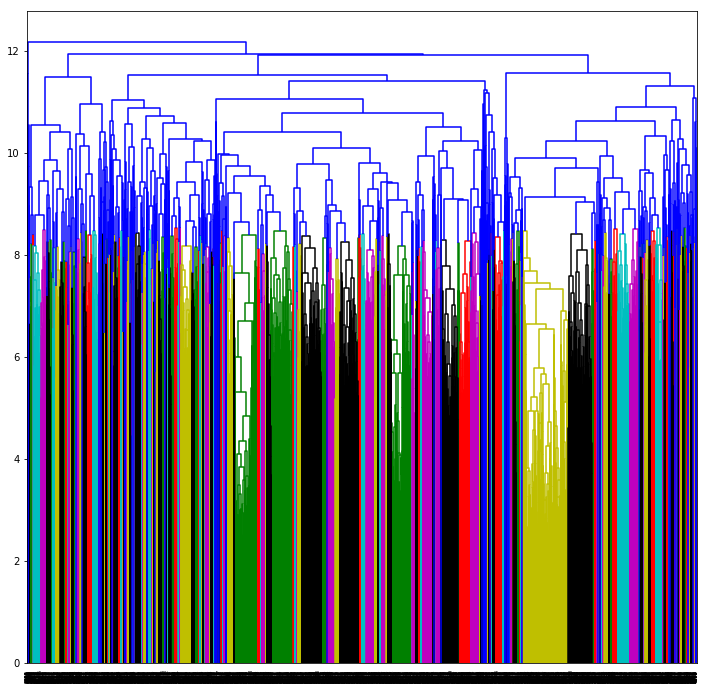

In [326]:
Z = linkage(x_k,'weighted')
plt.figure(figsize=(12, 12))
_ = dendrogram(Z)

Average Method: Also looks pretty bad.

Overall the ward method seems to be the best

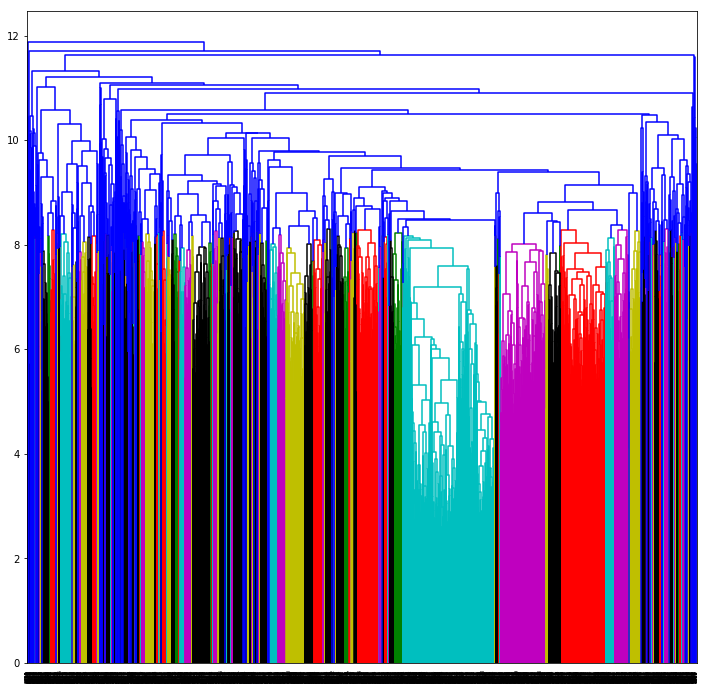

In [327]:
Z = linkage(x_k,'average')
plt.figure(figsize=(12, 12))
_ = dendrogram(Z)